In [1]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('woody_degrad.csv')
features.head(5)

,dem,dist2canal,saltwater_max,groundwater_max,gw_duration,degradation
0,0.38054,1471.223980,-0.219789,-0.004625,1.000000,1
1,0.23622,1500.299970,-0.071583,0.123283,1.000000,1
2,0.33377,1530.294089,-0.169133,0.025733,1.000000,1
3,0.47378,1560.288435,-0.307434,-0.192245,0.986301,1
4,0.34838,1500.000000,-0.188293,0.090398,0.920548,1


In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (15404, 6)


In [3]:
features = pd.DataFrame(features)

In [4]:
features

,dem,dist2canal,saltwater_max,groundwater_max,gw_duration,degradation
0,0.380540,1471.223980,-0.219789,-0.004625,1.000000,1
1,0.236220,1500.299970,-0.071583,0.123283,1.000000,1
2,0.333770,1530.294089,-0.169133,0.025733,1.000000,1
3,0.473780,1560.288435,-0.307434,-0.192245,0.986301,1
4,0.348380,1500.000000,-0.188293,0.090398,0.920548,1
...,...,...,...,...,...,...
15399,0.484160,3761.980861,-0.290103,-0.082835,0.877049,2
15400,0.041831,3853.336217,0.219596,0.314767,0.268493,2
15401,0.008813,3812.833592,0.232474,0.325290,0.235616,2
15402,0.021208,3805.390913,0.201926,0.347551,0.243836,2


In [5]:
features['degradation'].value_counts()

1    13219
2     2185
Name: degradation, dtype: int64

In [6]:
from sklearn.utils import resample

df_majority = features[features.degradation==1]
df_minority = features[features.degradation==2]

df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=13219,   # to match majority class
                                 random_state=123) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.degradation.value_counts()

1    13219
2    13219
Name: degradation, dtype: int64

In [7]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we "want to predict
labels = np.array(df_upsampled['degradation'])
# Remove the labels from the features
# axis 1 refers to the columns
df_upsampled= df_upsampled.drop('degradation', axis = 1)
# Saving feature names for later use
feature_list = list(df_upsampled.columns)
# Convert to numpy array
features = np.array(df_upsampled)

In [8]:
features.shape

(26438, 5)

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [10]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (19828, 5)
Training Labels Shape: (19828,)
Testing Features Shape: (6610, 5)
Testing Labels Shape: (6610,)


In [11]:
# Import the model we are using
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestRegressor(random_state=21)

In [12]:
param_grid = {'min_samples_split': [2, 5, 10],
              'max_depth': [2, 8, 16],
              'max_features': ['sqrt','log2'],
              'n_estimators': [10,50,100,500,1000,2000],
              'min_samples_leaf': [1, 2, 4]}

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
gd_sr = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring='r2',
                     cv=KFold(n_splits=3, shuffle=True, random_state=21),
                     error_score="raise")

In [14]:
import warnings

warnings.filterwarnings('ignore')

gd_sr_res = gd_sr.fit(train_features, train_labels)

In [15]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [16]:
best_result = gd_sr.best_score_
print(best_result)

0.7439659311944027


In [17]:
# Import the model we are using
import sklearn.ensemble
# Instantiate model with 500 decision trees
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=2000, random_state=21, min_samples_split = 2,min_samples_leaf = 1, max_depth = 16, max_features = 'sqrt')
# Train the model on training data
clf = clf.fit(train_features, train_labels);

In [18]:
# Use the forest's predict method on the test data
predictions = clf.predict(test_features)
#Assess the accuracy using the validation dataset
print('Accuracy:',clf.score(test_features,test_labels))

Accuracy: 0.9354009077155825


In [19]:
from sklearn.metrics import roc_auc_score
prob_y = clf.predict_proba(test_features)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(test_labels, prob_y))

0.993790527608764


In [20]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dist2canal           Importance: 0.31
Variable: dem                  Importance: 0.2
Variable: saltwater_max        Importance: 0.19
Variable: groundwater_max      Importance: 0.17
Variable: gw_duration          Importance: 0.12


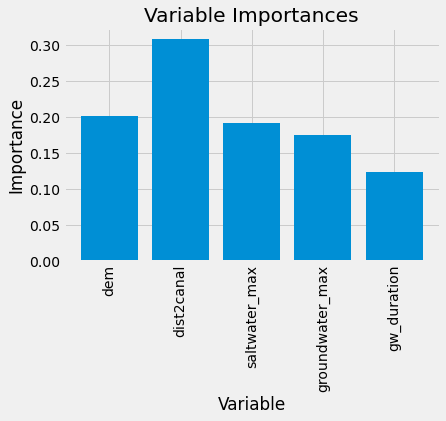

In [21]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');